# Scrape movie sequel data from Box Office Mojo 

In [280]:
import requests
import time
import random
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import sklearn

import seaborn as sns
from bs4 import BeautifulSoup

Get data from Box Office Mojo. This doesn't lump in Marvel Cinematic Universe data as one series (or other examples), only includes movies in box office (as direct to video sales are very spotty)

## Scrape list of franchises and franchise summary webpages

In [333]:
url = 'http://www.boxofficemojo.com/franchises/'
response = requests.get(url)
response.status_code
# print(response.text)
page = response.text
soup = BeautifulSoup(page,"lxml")

Get list of webpage links for franchises

In [334]:
site_link = 'http://www.boxofficemojo.com/franchises'
franchise_table = soup.find_all('table')[3]
franchise_links = []
franchise_list = []
for franchise in franchise_table.find_all('tr')[1:]:
    franchise_links.append(site_link + (franchise.find('a')['href'][1:]))
    franchise_list.append(franchise.find('a').text)
print(franchise_links[:5])
print(franchise_list[:5])

['http://www.boxofficemojo.com/franchises/chart/?id=3ninjas.htm', 'http://www.boxofficemojo.com/franchises/chart/?id=300.htm', 'http://www.boxofficemojo.com/franchises/chart/?id=agathachristie.htm', 'http://www.boxofficemojo.com/franchises/chart/?id=alexcross.htm', 'http://www.boxofficemojo.com/franchises/chart/?id=aliceinwonderland.htm']
['3 Ninjas', '300', 'Agatha Christie', 'Alex Cross', 'Alice in Wonderland']


In [335]:
print(f'There are {len(franchise_links)} movie franchises with at least one box office sequel.')

There are 254 movie franchises with at least one box office sequel.


## Proof of concept for webscrape to data frame pipeline: single franchise, theater and movie title data

Scrape basic movie data (7 features) from the summary page for each franchise - rank, title, adjusted gross domestic, gross theathers, adjusted opening, adjusted theaters, release date, plus a list of individual movie websites for getting more data if needed.

In [339]:
franchise_name = []
movie_title = []
theaters = []
"""
number of theaters is in the 4th table, not the 5th table - will have to generate
a separate for loop to get this value
theater_raw = franchise.find_all('td')[4].text
    theaters.append(theater_raw.replace(',',''))
    # need to convert to datetime object
"""


url = 'http://www.boxofficemojo.com/franchises/chart/?id=3ninjas.htm'
response = requests.get(url)
# print(response.status_code)
page = response.text
soup = BeautifulSoup(page,"lxml")

In [348]:
theater_table = soup.find_all('table')[4]
for franchise in theater_table.find_all('tr')[1:-2]:
    movie_title.append(franchise.find_all('td')[1].text)
    n_theaters = franchise.find_all('td')[4].text
    theaters.append(int(n_theaters.replace(',','')))
    franchise_name.append(soup.find('h1').text)

In [5]:
franchise_table = soup.find_all('table')[4]
for franchise in franchise_table.find_all('tr')[1:-2]:
    movie_title.append(franchise.find_all('td')[1].text)
    n_theaters = franchise.find_all('td')[4].text[1:]
    adjusted_domestic_gross.append(int(adj_domestic_gross_str.replace(',', '')))
    franchise_name.append(soup.find('h1').text)
    movie_webpage.append(site_link + franchise.find('a')['href'])

In [6]:
df = pd.DataFrame(
    {'franchise_name': franchise_name,
     'movie_title': movie_title,
     'rank': rank,
     'studio': studio,
     'adjusted_domestic_gross': adjusted_domestic_gross,
#     'n_theaters': theaters,
     'release_date': release,
    })

In [7]:
movie_webpage

['http://www.boxofficemojo.com/franchises/movies/?id=3ninjas.htm',
 'http://www.boxofficemojo.com/franchises/movies/?id=3ninjaskickback.htm',
 'http://www.boxofficemojo.com/franchises/movies/?id=3ninjasknuckleup.htm',
 'http://www.boxofficemojo.com/franchises/movies/?id=3ninjas4.htm']

In [8]:
df.head()

,franchise_name,movie_title,rank,studio,adjusted_domestic_gross,release_date
0,3 Ninjas,3 Ninjas,1,BV,64010300,1992-08-07
1,3 Ninjas,3 Ninjas Kick Back,2,TriS,25855900,1994-05-06
2,3 Ninjas,3 Ninjas Knuckle Up,3,Sony,870700,1995-03-10
3,3 Ninjas,3 Ninjas: High Noon at Mega Mountain,4,Sony,734000,1998-04-10


Create variables 'prior_movie_date' and 'prior_movie_studio', then get the difference between the two.  The value for the first movie in each franchise will be NaN because there is no previous movie to compare it to. 

In [9]:
df = df.sort_values(by=['franchise_name', 'release_date'])

In [10]:
df[['prior_movie_studio', 'prior_movie_release_date']] = df.groupby(['franchise_name'])['studio','release_date'].transform(lambda grp: grp.shift(1))

In [11]:
df.head()

,franchise_name,movie_title,rank,studio,adjusted_domestic_gross,release_date,prior_movie_studio,prior_movie_release_date
0,3 Ninjas,3 Ninjas,1,BV,64010300,1992-08-07,NaN,NaT
1,3 Ninjas,3 Ninjas Kick Back,2,TriS,25855900,1994-05-06,BV,1992-08-07
2,3 Ninjas,3 Ninjas Knuckle Up,3,Sony,870700,1995-03-10,TriS,1994-05-06
3,3 Ninjas,3 Ninjas: High Noon at Mega Mountain,4,Sony,734000,1998-04-10,Sony,1995-03-10


Get difference between release dates. 

In [12]:
df['time_since_prior_movie'] = df.release_date - df.prior_movie_release_date

In [13]:
df.head()

,franchise_name,movie_title,rank,studio,adjusted_domestic_gross,release_date,prior_movie_studio,prior_movie_release_date,time_since_prior_movie
0,3 Ninjas,3 Ninjas,1,BV,64010300,1992-08-07,NaN,NaT,NaT
1,3 Ninjas,3 Ninjas Kick Back,2,TriS,25855900,1994-05-06,BV,1992-08-07,637 days
2,3 Ninjas,3 Ninjas Knuckle Up,3,Sony,870700,1995-03-10,TriS,1994-05-06,308 days
3,3 Ninjas,3 Ninjas: High Noon at Mega Mountain,4,Sony,734000,1998-04-10,Sony,1995-03-10,1127 days


## Generalizing to the full dataset: scraping basic features from 254 franchises
Pickle the raw data file when done - takes about an hour to scrape with the time delay. 

In [14]:
franchise_links[0:10]

['http://www.boxofficemojo.com/franchises/chart/?id=3ninjas.htm',
 'http://www.boxofficemojo.com/franchises/chart/?id=300.htm',
 'http://www.boxofficemojo.com/franchises/chart/?id=agathachristie.htm',
 'http://www.boxofficemojo.com/franchises/chart/?id=alexcross.htm',
 'http://www.boxofficemojo.com/franchises/chart/?id=aliceinwonderland.htm',
 'http://www.boxofficemojo.com/franchises/chart/?id=alien.htm',
 'http://www.boxofficemojo.com/franchises/chart/?id=alvinseries.htm',
 'http://www.boxofficemojo.com/franchises/chart/?id=americanninja.htm',
 'http://www.boxofficemojo.com/franchises/chart/?id=americanpie.htm',
 'http://www.boxofficemojo.com/franchises/chart/?id=amityville.htm']

In [601]:
"""
number of theaters is in the 4th table, not the 5th table - will have to generate
a separate for loop to get this value
theater_raw = franchise.find_all('td')[4].text
    theaters.append(theater_raw.replace(',',''))
    # need to convert to datetime object.
    There are a few movie sequels with the exact same name. 
    To avoid issues with merges, always get the franchise, movie title
    and the release date. 
"""

franchise_name = []
movie_title = []
rank = []
studio = []
adjusted_domestic_gross = []
n_theaters = []
release = []
movie_webpage = []
theater_movie_title = []
theater_franchise_name = []
theater_release = []

for url in franchise_links: 
    response = requests.get(url)
    # print(response.status_code)
    page = response.text
    soup = BeautifulSoup(page,"lxml")

    franchise_table = soup.find_all('table')[5]
    for franchise in franchise_table.find_all('tr')[1:-2]:
        movie_title.append(franchise.find_all('td')[1].text)
        rank.append(int(franchise.find_all('td')[0].text))
        studio.append(franchise.find_all('td')[2].text)
        adj_domestic_gross_str = franchise.find_all('td')[3].text[1:]
        adjusted_domestic_gross.append(int(adj_domestic_gross_str.replace(',', '')))
        release_str = franchise.find_all('td')[5].text
        release.append(pd.to_datetime(release_str))
        franchise_name.append(soup.find('h1').text)
        movie_webpage.append(site_link + franchise.find('a')['href'])

    theater_table = soup.find_all('table')[4]
    for franchise in theater_table.find_all('tr')[1:-2]:
        theater_movie_title.append(franchise.find_all('td')[1].text)
        theaters = franchise.find_all('td')[4].text
        n_theaters.append(int(theaters.replace(',','').replace('-','0')))
        theater_franchise_name.append(soup.find('h1').text)
        theater_release_str = franchise.find_all('td')[7].text
        if theater_release_str != 'N/A':
            theater_release.append(pd.to_datetime(theater_release_str))
        else:
            theater_release.append(np.NaN)
    print(f'Next scrape in {int(sec)} seconds. Just finished {franchise_name[-1]}.')
    sec = random.uniform(5,12)
    time.sleep(sec)    


df = pd.DataFrame(
    {'franchise_name': franchise_name,
     'movie_title': movie_title,
     'rank': rank,
     'studio': studio,
     'adjusted_domestic_gross': adjusted_domestic_gross,
     'release_date': release,
    })

df_theater = pd.DataFrame(
    {'franchise_name': theater_franchise_name,
     'movie_title': theater_movie_title,
     'theaters': n_theaters,
     'release_date': theater_release
    })

Next scrape in 5 seconds. Just finished 3 Ninjas.
Next scrape in 6 seconds. Just finished 300.
Next scrape in 6 seconds. Just finished Agatha Christie.
Next scrape in 7 seconds. Just finished Alex Cross.
Next scrape in 8 seconds. Just finished Alice in Wonderland.
Next scrape in 9 seconds. Just finished Alien.
Next scrape in 5 seconds. Just finished Alvin and the Chipmunks.
Next scrape in 11 seconds. Just finished American Ninja.
Next scrape in 9 seconds. Just finished American Pie.
Next scrape in 6 seconds. Just finished Amityville.
Next scrape in 5 seconds. Just finished Angry Birds.
Next scrape in 7 seconds. Just finished Annabelle.
Next scrape in 5 seconds. Just finished Ant-Man.
Next scrape in 8 seconds. Just finished Arthur.
Next scrape in 6 seconds. Just finished Atlas Shrugged Franchise.
Next scrape in 11 seconds. Just finished Austin Powers.
Next scrape in 6 seconds. Just finished Avatar.
Next scrape in 10 seconds. Just finished Avengers.
Next scrape in 10 seconds. Just finish

Next scrape in 9 seconds. Just finished The Mummy.
Next scrape in 8 seconds. Just finished The Muppets.
Next scrape in 6 seconds. Just finished My Big Fat Greek Wedding.
Next scrape in 10 seconds. Just finished The Naked Gun.
Next scrape in 11 seconds. Just finished Neighbors.
Next scrape in 9 seconds. Just finished The Neverending Story.
Next scrape in 10 seconds. Just finished Night at the Museum.
Next scrape in 11 seconds. Just finished Nightmare on Elm Street.
Next scrape in 11 seconds. Just finished Now You See Me.
Next scrape in 5 seconds. Just finished The Nut Job.
Next scrape in 9 seconds. Just finished Ocean's 11.
Next scrape in 11 seconds. Just finished Oh, God!.
Next scrape in 10 seconds. Just finished The Omen.
Next scrape in 11 seconds. Just finished Ong Bak.
Next scrape in 11 seconds. Just finished Ouija.
Next scrape in 6 seconds. Just finished Pacific Rim.
Next scrape in 9 seconds. Just finished Paddington Bear.
Next scrape in 10 seconds. Just finished Paranormal Activit

In [624]:
mask = (df_theater['movie_title'].str.contains("(Re-release)"))
df_theater[mask]

/Users/courtney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


26

/Users/courtney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
953    False
954    False
955    False
956    False
957    False
958    False
959    False
960    False
961    False
962    False
963    False
964    False
965    False
966    False
967    False
968    False
969    False
970    False
971    False
972    False
973    False
974    False
975    False
976    False
977    False
978    False
979    False
980    False
981    False
982    False
Name: movie_title, Length: 983, dtype: bool

In [613]:
df = pd.merge(df_theater, df, how='right', on=['franchise_name','movie_title','release_date'])

In [617]:
df.tail()

,franchise_name,movie_title,theaters,release_date,rank,studio,adjusted_domestic_gross
969,Star Wars,Star Wars (Re-issue),NaN,1982-08-13,15,Fox,48218600
970,Star Wars,The Empire Strikes Back (Re-issue),NaN,1982-11-19,17,Fox,41364100
971,Star Wars,Return of the Jedi (Re-issue),NaN,1985-03-29,18,Fox,29033600
972,Star Wars,Attack of the Clones: The IMAX Experience (IMAX),NaN,2002-11-01,19,Fox,13338800
973,Texas Chainsaw Massacre,Texas Chainsaw Massacre: The Next Generation,NaN,1997-08-29,7,Lions,282600


In [615]:
with open('raw_movie_data.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

## Clean the data and create some new variables 

* Replace ranking variable with index of data sorted by release date, by group
* Create a different Y variable - sequel domestic gross as a percentage of the first movie's domestic gross - NOT THIS ONE - BASED ON THE FUTURE
* Create a third transformed Y variable - sequel domestic gross as a percentage of the total franchises' money
* Create a fourth transformed Y variable - sequel domestic gross as a percentage of the most recent movie's domestic gross

In [365]:
n_theaters

[1954,
 2043,
 52,
 120,
 3280,
 3490,
 3354,
 2573,
 2406,
 2541,
 3739,
 3763,
 3442,
 1454,
 3401,
 757,
 3772,
 2227,
 2449,
 2617,
 3747,
 3499,
 3734,
 3705,
 916,
 672,
 397,
 140,
 171,
 3157,
 3175,
 2544,
 3203,
 748,
 3323,
 1200,
 1254,
 10,
 3932,
 3565,
 3215,
 3868,
 4206,
 701,
 3276,
 1426,
 465,
 1012,
 242,
 3613,
 3314,
 2187,
 3461,
 812,
 4474,
 4349,
 4276,
 1550,
 2107,
 2070,
 3202,
 2132,
 3215,
 3615,
 3183]

In [69]:
with open('raw_movie_data.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [70]:
df = df.sort_values(by=['franchise_name', 'release_date'])

In [71]:
df[['prior_movie_studio', 'prior_movie_release_date']] = df.groupby(['franchise_name'])['studio','release_date'].transform(lambda grp: grp.shift(1))

In [199]:
df['prior_movie_adj_domestic_gross'] = df.groupby(['franchise_name'])['adjusted_domestic_gross'].transform(lambda grp: grp.shift(1))

In [200]:
df.head()

,franchise_name,movie_title,rank,studio,adjusted_domestic_gross,release_date,prior_movie_studio,prior_movie_release_date,time_since_prior_movie,first_movie_release_date,time_since_first_movie,first_movie_adj_domestic_gross,percent_gross_change_vs_first_movie,time_since_prior_movie_int,time_since_first_movie_int,ln_adj_domestic_gross,order,prior_movie_adj_domestic_gross
0,3 Ninjas,3 Ninjas,1,BV,64010300,1992-08-07,NaN,NaT,NaT,1992-08-07,0 days,64010300,1.000000,NaN,0,17.974555,1,NaN
1,3 Ninjas,3 Ninjas Kick Back,2,TriS,25855900,1994-05-06,BV,1992-08-07,637 days,1992-08-07,637 days,64010300,0.403933,637.0,637,17.068049,2,64010300.0
2,3 Ninjas,3 Ninjas Knuckle Up,3,Sony,870700,1995-03-10,TriS,1994-05-06,308 days,1992-08-07,945 days,64010300,0.013602,308.0,945,13.677053,3,25855900.0
3,3 Ninjas,3 Ninjas: High Noon at Mega Mountain,4,Sony,734000,1998-04-10,Sony,1995-03-10,1127 days,1992-08-07,2072 days,64010300,0.011467,1127.0,2072,13.506264,4,870700.0
4,300,300,1,WB,280411700,2007-03-09,NaN,NaT,NaT,2007-03-09,0 days,280411700,1.000000,NaN,0,19.451769,1,NaN


In [72]:
df['time_since_prior_movie'] = df.release_date - df.prior_movie_release_date

In [73]:
# Ask the teachers if there's a better way to do this
franchise_start_date = df.groupby(by='franchise_name')['release_date'].min().reset_index()
franchise_start_date.columns = ['franchise_name', 'first_movie_release_date']
df = pd.merge(df,franchise_start_date,on='franchise_name')

In [74]:
df['time_since_first_movie'] = df.release_date - df.first_movie_release_date

In [75]:
# get first of each domestic gross for the first movie of each franchise, add that as a column, then divide current movie's gross by that
first_movie_adj_domestic_gross = pd.DataFrame(df.groupby(by=['franchise_name'])['adjusted_domestic_gross'].first())

In [76]:
first_movie_adj_domestic_gross.head()

,adjusted_domestic_gross
franchise_name,
3 Ninjas,64010300
300,280411700
A Haunted House,46194200
Agatha Christie,102608700
Alex Cross,120792000


In [77]:
first_movie_adj_domestic_gross.columns = ['first_movie_adj_domestic_gross']

In [78]:
first_movie_adj_domestic_gross.head()

,first_movie_adj_domestic_gross
franchise_name,
3 Ninjas,64010300
300,280411700
A Haunted House,46194200
Agatha Christie,102608700
Alex Cross,120792000


In [79]:
df = pd.merge(df,first_movie_adj_domestic_gross,on='franchise_name')

In [81]:
df['percent_gross_change_vs_first_movie'] = df.adjusted_domestic_gross/df.first_movie_adj_domestic_gross

In [130]:
df['ln_adj_domestic_gross'] = np.log(df.adjusted_domestic_gross)

In [210]:
df['ln_prior_movie_adj_domestic_gross'] = np.log(df.prior_movie_adj_domestic_gross)

In [241]:
df['ln_first_movie_adj_domestic_gross'] = np.log(df.first_movie_adj_domestic_gross)

In [307]:
# see if a change in the studio from the last movie to this one impacts the outcome
test = df.head()
df.studio_changed_vs_prior_movie = np.where(df.studio == df.prior_movie_studio, 0, 1)
df.studio_changed_vs_prior_movie[df.order == 1] = np.NaN

/Users/courtney/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [308]:
df.head()

,franchise_name,movie_title,rank,studio,adjusted_domestic_gross,release_date,prior_movie_studio,prior_movie_release_date,time_since_prior_movie,first_movie_release_date,...,first_movie_adj_domestic_gross,percent_gross_change_vs_first_movie,time_since_prior_movie_int,time_since_first_movie_int,ln_adj_domestic_gross,order,prior_movie_adj_domestic_gross,ln_prior_movie_adj_domestic_gross,ln_first_movie_adj_domestic_gross,studio_changed_vs_prior_movie
0,3 Ninjas,3 Ninjas,1,BV,64010300,1992-08-07,NaN,NaT,NaT,1992-08-07,...,64010300,1.000000,NaN,0,17.974555,1,NaN,NaN,17.974555,NaN
1,3 Ninjas,3 Ninjas Kick Back,2,TriS,25855900,1994-05-06,BV,1992-08-07,637 days,1992-08-07,...,64010300,0.403933,637.0,637,17.068049,2,64010300.0,17.974555,17.974555,1.0
2,3 Ninjas,3 Ninjas Knuckle Up,3,Sony,870700,1995-03-10,TriS,1994-05-06,308 days,1992-08-07,...,64010300,0.013602,308.0,945,13.677053,3,25855900.0,17.068049,17.974555,1.0
3,3 Ninjas,3 Ninjas: High Noon at Mega Mountain,4,Sony,734000,1998-04-10,Sony,1995-03-10,1127 days,1992-08-07,...,64010300,0.011467,1127.0,2072,13.506264,4,870700.0,13.677053,17.974555,0.0
4,300,300,1,WB,280411700,2007-03-09,NaN,NaT,NaT,2007-03-09,...,280411700,1.000000,NaN,0,19.451769,1,NaN,NaN,19.451769,NaN


In [232]:
df.head()

,franchise_name,movie_title,rank,studio,adjusted_domestic_gross,release_date,prior_movie_studio,prior_movie_release_date,time_since_prior_movie,first_movie_release_date,time_since_first_movie,first_movie_adj_domestic_gross,percent_gross_change_vs_first_movie,time_since_prior_movie_int,time_since_first_movie_int,ln_adj_domestic_gross,order,prior_movie_adj_domestic_gross,ln_prior_movie_adj_domestic_gross
0,3 Ninjas,3 Ninjas,1,BV,64010300,1992-08-07,NaN,NaT,NaT,1992-08-07,0 days,64010300,1.000000,NaN,0,17.974555,1,NaN,NaN
1,3 Ninjas,3 Ninjas Kick Back,2,TriS,25855900,1994-05-06,BV,1992-08-07,637 days,1992-08-07,637 days,64010300,0.403933,637.0,637,17.068049,2,64010300.0,17.974555
2,3 Ninjas,3 Ninjas Knuckle Up,3,Sony,870700,1995-03-10,TriS,1994-05-06,308 days,1992-08-07,945 days,64010300,0.013602,308.0,945,13.677053,3,25855900.0,17.068049
3,3 Ninjas,3 Ninjas: High Noon at Mega Mountain,4,Sony,734000,1998-04-10,Sony,1995-03-10,1127 days,1992-08-07,2072 days,64010300,0.011467,1127.0,2072,13.506264,4,870700.0,13.677053
4,300,300,1,WB,280411700,2007-03-09,NaN,NaT,NaT,2007-03-09,0 days,280411700,1.000000,NaN,0,19.451769,1,NaN,NaN


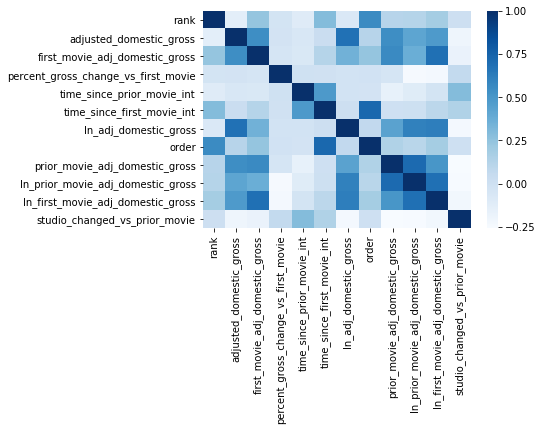

In [309]:
sns.heatmap(df.corr(), cmap="Blues")

In [274]:
df.corr()

,rank,adjusted_domestic_gross,first_movie_adj_domestic_gross,percent_gross_change_vs_first_movie,time_since_prior_movie_int,time_since_first_movie_int,ln_adj_domestic_gross,order,prior_movie_adj_domestic_gross,ln_prior_movie_adj_domestic_gross,ln_first_movie_adj_domestic_gross
rank,1.000000,-0.134437,0.241287,-0.027372,-0.101773,0.293934,-0.073450,0.562252,0.117729,0.123388,0.187954
adjusted_domestic_gross,-0.134437,1.000000,0.546120,-0.024498,-0.059859,0.034268,0.684402,0.116756,0.545234,0.422742,0.482054
first_movie_adj_domestic_gross,0.241287,0.546120,1.000000,-0.038479,-0.067414,0.122397,0.355320,0.241287,0.564189,0.375813,0.686345
percent_gross_change_vs_first_movie,-0.027372,-0.024498,-0.038479,1.000000,0.002001,-0.006820,-0.021711,-0.014309,-0.040951,-0.239244,-0.231302
time_since_prior_movie_int,-0.101773,-0.059859,-0.067414,0.002001,1.000000,0.485635,-0.021227,-0.024059,-0.155296,-0.107842,-0.027587
time_since_first_movie_int,0.293934,0.034268,0.122397,-0.006820,0.485635,1.000000,0.016447,0.725525,0.005309,0.010835,0.100390
ln_adj_domestic_gross,-0.073450,0.684402,0.355320,-0.021711,-0.021227,0.016447,1.000000,0.075901,0.437407,0.607809,0.622645
order,0.562252,0.116756,0.241287,-0.014309,-0.024059,0.725525,0.075901,1.000000,0.143518,0.107044,0.187954
prior_movie_adj_domestic_gross,0.117729,0.545234,0.564189,-0.040951,-0.155296,0.005309,0.437407,0.143518,1.000000,0.716233,0.505015
ln_prior_movie_adj_domestic_gross,0.123388,0.422742,0.375813,-0.239244,-0.107842,0.010835,0.607809,0.107044,0.716233,1.000000,0.688464


### Remove all first movies in franchises - look only at 2nd and onward

In [319]:
mask = (df.order > 1)
sequel_df = df[mask]

In [320]:
sequel_df.tail()

,franchise_name,movie_title,rank,studio,adjusted_domestic_gross,release_date,prior_movie_studio,prior_movie_release_date,time_since_prior_movie,first_movie_release_date,...,first_movie_adj_domestic_gross,percent_gross_change_vs_first_movie,time_since_prior_movie_int,time_since_first_movie_int,ln_adj_domestic_gross,order,prior_movie_adj_domestic_gross,ln_prior_movie_adj_domestic_gross,ln_first_movie_adj_domestic_gross,studio_changed_vs_prior_movie
966,X-Men,Logan,7,Fox,234205600,2017-03-03,Fox,2016-05-27,280 days,2000-07-14,...,267322000,0.876118,280.0,6076,19.271710,10,163176100.0,18.910341,19.403964,0.0
967,X-Men,Deadpool 2,4,Fox,315073000,2018-05-18,Fox,2017-03-03,441 days,2000-07-14,...,267322000,1.178627,441.0,6517,19.568315,11,234205600.0,19.271710,19.403964,0.0
969,Zoolander,Zoolander 2,2,Par.,30798800,2016-02-12,Par.,2001-09-28,5250 days,2001-09-28,...,73101000,0.421318,5250.0,5250,17.242986,2,73101000.0,18.107353,18.107353,0.0
971,xXx Trilogy,XXX: State of the Union,3,SonR,38403300,2005-04-29,SonR,2002-08-09,994 days,2002-08-09,...,224031900,0.171419,994.0,994,17.463654,2,224031900.0,19.227299,19.227299,0.0
972,xXx Trilogy,xXx: The Return of Xander Cage,2,Par.,46523700,2017-01-20,SonR,2005-04-29,4284 days,2002-08-09,...,224031900,0.207666,4284.0,5278,17.655472,3,38403300.0,17.463654,19.227299,1.0


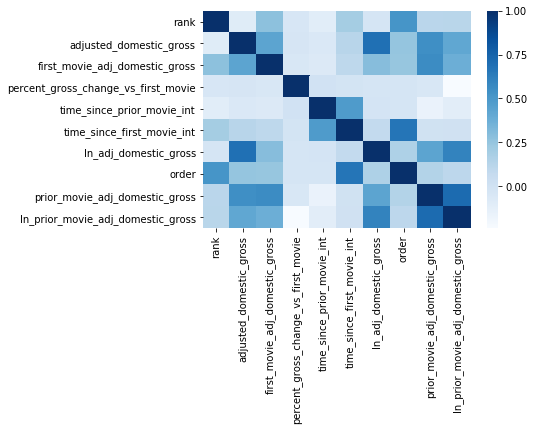

In [243]:
sns.heatmap(sequel_df.corr(), cmap="Blues")

In [222]:
mask = (df.order > 2)
third_on_df = df[mask] 

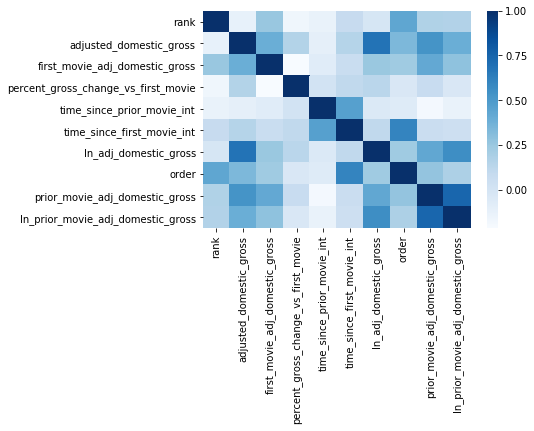

In [244]:
sns.heatmap(third_on_df.corr(), cmap="Blues")

### Order of movie in the franchise
'rank' from BoxOfficeMojo is the rank by box office, not release order

In [231]:
df.head()

,franchise_name,movie_title,rank,studio,adjusted_domestic_gross,release_date,prior_movie_studio,prior_movie_release_date,time_since_prior_movie,first_movie_release_date,time_since_first_movie,first_movie_adj_domestic_gross,percent_gross_change_vs_first_movie,time_since_prior_movie_int,time_since_first_movie_int,ln_adj_domestic_gross,order,prior_movie_adj_domestic_gross,ln_prior_movie_adj_domestic_gross
0,3 Ninjas,3 Ninjas,1,BV,64010300,1992-08-07,NaN,NaT,NaT,1992-08-07,0 days,64010300,1.000000,NaN,0,17.974555,1,NaN,NaN
1,3 Ninjas,3 Ninjas Kick Back,2,TriS,25855900,1994-05-06,BV,1992-08-07,637 days,1992-08-07,637 days,64010300,0.403933,637.0,637,17.068049,2,64010300.0,17.974555
2,3 Ninjas,3 Ninjas Knuckle Up,3,Sony,870700,1995-03-10,TriS,1994-05-06,308 days,1992-08-07,945 days,64010300,0.013602,308.0,945,13.677053,3,25855900.0,17.068049
3,3 Ninjas,3 Ninjas: High Noon at Mega Mountain,4,Sony,734000,1998-04-10,Sony,1995-03-10,1127 days,1992-08-07,2072 days,64010300,0.011467,1127.0,2072,13.506264,4,870700.0,13.677053
4,300,300,1,WB,280411700,2007-03-09,NaN,NaT,NaT,2007-03-09,0 days,280411700,1.000000,NaN,0,19.451769,1,NaN,NaN


In [182]:
name = df.franchise_name[0]
counter = 1
rank_list = []
for i in df.franchise_name: 
    if i == name:
        rank_list.append(counter)
        counter+=1
    else:
        counter = 1
        rank_list.append(counter)
        counter+=1
        name = i
df['order'] = np.array(rank_list)

In [198]:
df.columns

Index(['franchise_name', 'movie_title', 'rank', 'studio',
       'adjusted_domestic_gross', 'release_date', 'prior_movie_studio',
       'prior_movie_release_date', 'time_since_prior_movie',
       'first_movie_release_date', 'time_since_first_movie',
       'first_movie_adj_domestic_gross', 'percent_gross_change_vs_first_movie',
       'time_since_prior_movie_int', 'time_since_first_movie_int',
       'ln_adj_domestic_gross', 'order'],
      dtype='object')

## Quick viz 

In [25]:
import matplotlib.pyplot as plt

In [84]:
df['time_since_prior_movie_int'] = df.time_since_prior_movie.dt.days

In [85]:
df['time_since_first_movie_int'] = df.time_since_first_movie.dt.days

(0, 1500)

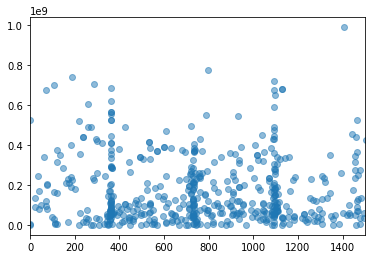

In [256]:
x = df.time_since_prior_movie_int
y = df.adjusted_domestic_gross

plt.scatter(x,y, alpha = 0.5);
plt.xlim(0,1500)

(0, 10)

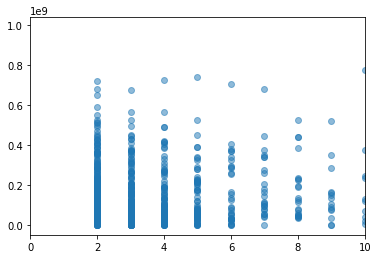

In [191]:
mask = (df.order > 1)
x = df.order[mask]
y = df.adjusted_domestic_gross[mask]

plt.scatter(x,y, alpha = 0.5);
plt.xlim(0,10)

(0, 2)

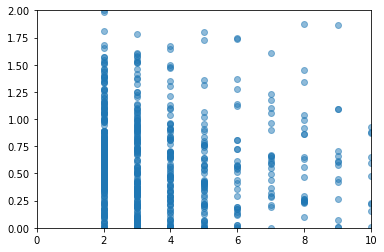

In [194]:
mask = (df.order > 1)
x = df.order[mask]
y = df.percent_gross_change_vs_first_movie[mask]

plt.scatter(x,y, alpha = 0.5);
plt.xlim(0,10)
plt.ylim(0,2)

(0, 10)

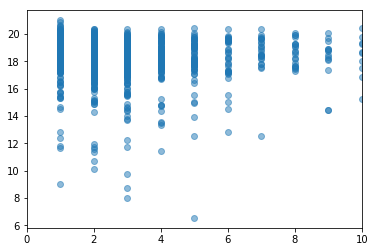

In [197]:
mask = (df.order > 1)
x = df.order#[mask]
y = df.ln_adj_domestic_gross#[mask]

plt.scatter(x,y, alpha = 0.5);
plt.xlim(0,10)
# plt.ylim(0,2)

(0, 10000)

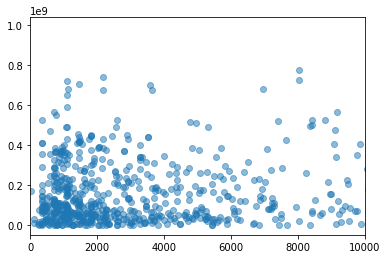

In [111]:
mask = (df.time_since_first_movie_int > 0)
x = df.time_since_first_movie_int[mask]
y = df.adjusted_domestic_gross[mask]

plt.scatter(x,y, alpha = 0.5);
plt.xlim(0,10000)

In [240]:
df.groupby(by='time_since_prior_movie_int').size().sort_values(ascending=False).head()

time_since_prior_movie_int
364.0     30
728.0     18
1092.0    18
735.0     12
1099.0    11
dtype: int64

(0, 1200)

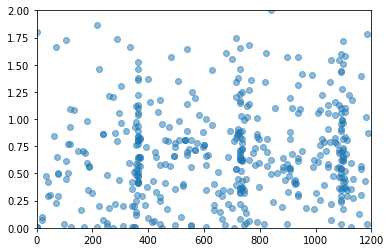

In [273]:
x = df.time_since_prior_movie_int
y = df.percent_gross_change_vs_first_movie

plt.scatter(x,y, alpha = 0.5);
plt.ylim(0,2)
plt.xlim(0,1200)

(0, 2000)

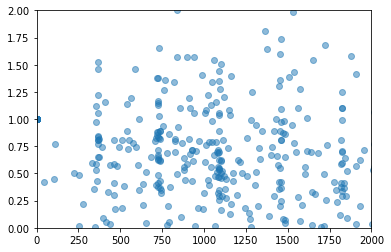

In [118]:
x = df.time_since_first_movie_int
y = df.percent_gross_change_vs_first_movie

plt.scatter(x,y, alpha = 0.5);
plt.ylim(0,2)
plt.xlim(0,2000)

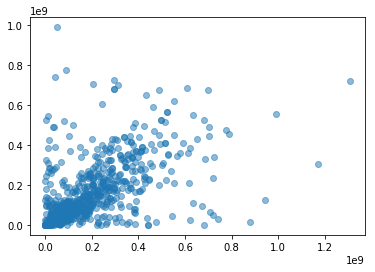

In [254]:
x = df.prior_movie_adj_domestic_gross
y = df.adjusted_domestic_gross

plt.scatter(x,y, alpha = 0.5);
#plt.ylim(0,2)
#plt.xlim(0,1000000)

Text(0,0.5,'next movie domestic gross\n(ln $, inflation adj)')

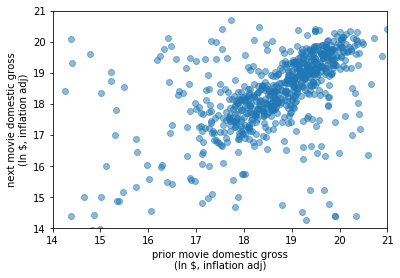

In [271]:
x = df.ln_prior_movie_adj_domestic_gross
y = df.ln_adj_domestic_gross

plt.scatter(x,y, alpha = 0.5);
plt.ylim(14,21)
plt.xlim(14,21)
plt.xlabel('prior movie domestic gross\n(ln $, inflation adj)')
plt.ylabel('next movie domestic gross\n(ln $, inflation adj)')

In [ ]:
df.groupby('')

In [200]:
df.head()

,franchise_name,movie_title,rank,studio,adjusted_domestic_gross,release_date,prior_movie_studio,prior_movie_release_date,time_since_prior_movie,first_movie_release_date,time_since_first_movie,first_movie_adj_domestic_gross,percent_gross_change_vs_first_movie,time_since_prior_movie_int,time_since_first_movie_int,ln_adj_domestic_gross,order,prior_movie_adj_domestic_gross
0,3 Ninjas,3 Ninjas,1,BV,64010300,1992-08-07,NaN,NaT,NaT,1992-08-07,0 days,64010300,1.000000,NaN,0,17.974555,1,NaN
1,3 Ninjas,3 Ninjas Kick Back,2,TriS,25855900,1994-05-06,BV,1992-08-07,637 days,1992-08-07,637 days,64010300,0.403933,637.0,637,17.068049,2,64010300.0
2,3 Ninjas,3 Ninjas Knuckle Up,3,Sony,870700,1995-03-10,TriS,1994-05-06,308 days,1992-08-07,945 days,64010300,0.013602,308.0,945,13.677053,3,25855900.0
3,3 Ninjas,3 Ninjas: High Noon at Mega Mountain,4,Sony,734000,1998-04-10,Sony,1995-03-10,1127 days,1992-08-07,2072 days,64010300,0.011467,1127.0,2072,13.506264,4,870700.0
4,300,300,1,WB,280411700,2007-03-09,NaN,NaT,NaT,2007-03-09,0 days,280411700,1.000000,NaN,0,19.451769,1,NaN


# First pass model

In [258]:
df.columns

Index(['franchise_name', 'movie_title', 'rank', 'studio',
       'adjusted_domestic_gross', 'release_date', 'prior_movie_studio',
       'prior_movie_release_date', 'time_since_prior_movie',
       'first_movie_release_date', 'time_since_first_movie',
       'first_movie_adj_domestic_gross', 'percent_gross_change_vs_first_movie',
       'time_since_prior_movie_int', 'time_since_first_movie_int',
       'ln_adj_domestic_gross', 'order', 'prior_movie_adj_domestic_gross',
       'ln_prior_movie_adj_domestic_gross',
       'ln_first_movie_adj_domestic_gross'],
      dtype='object')

In [321]:
y, X = patsy.dmatrices('ln_adj_domestic_gross ~ ln_prior_movie_adj_domestic_gross + ln_first_movie_adj_domestic_gross + time_since_prior_movie_int + time_since_first_movie_int + order + studio_changed_vs_prior_movie', data=sequel_df, return_type="dataframe")

model_a = sm.OLS(y, X)
fit_a = model_a.fit()
fit_a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ln_adj_domestic_gross   R-squared:                       0.404
Model:                               OLS   Adj. R-squared:                  0.399
Method:                    Least Squares   F-statistic:                     80.49
Date:                   Fri, 13 Jul 2018   Prob (F-statistic):           9.29e-77
Time:                           16:10:04   Log-Likelihood:                -1224.6
No. Observations:                    719   AIC:                             2463.
Df Residuals:                        712   BIC:                             2495.
Df Model:                              6                                         
Covariance Type:               nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             4.1699      0.751      5.553      0.000       2.696       5.644
ln_prior_movie_adj_domestic_gross     0.5467      0.047     11.696      0.000       0.455       0.639
ln_first_movie_adj_domestic_gross     0.1957      0.052      3.799      0.000       0.095       0.297
time_since_prior_movie_int         6.655e-05   3.22e-05      2.067      0.039    3.33e-06       0.000
time_since_first_movie_int        -1.351e-05   1.91e-05     -0.709      0.478   -5.09e-05    2.39e-05
order                                 0.0532      0.023      2.292      0.022       0.008       0.099
studio_changed_vs_prior_movie        -0.3891      0.125     -3.117      0.002      -0.634      -0.144
==============================================================================
Omnibus:                      364.054   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5166.172
Skew:                          -1.917   Prob(JB):                         0.00
Kurtosis:                      15.560   Cond. No.                     9.94e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.94e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

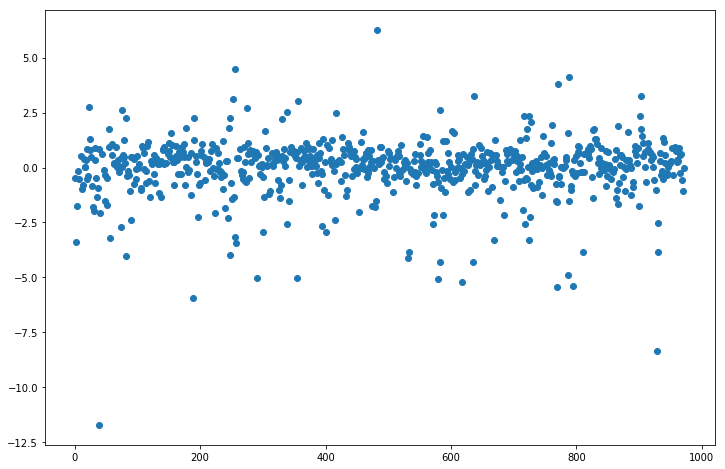

In [266]:
fit_a.resid.plot(style='o', figsize=(12,8));

(array([  1.,   1.,   0.,   8.,  16.,  70., 518.,  95.,   8.,   2.]),
 array([-11.72051469,  -9.92122912,  -8.12194355,  -6.32265798,
         -4.52337241,  -2.72408684,  -0.92480127,   0.8744843 ,
          2.67376987,   4.47305543,   6.272341  ]),
 <a list of 10 Patch objects>)

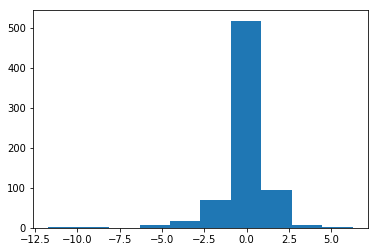

In [268]:
plt.hist(fit_a.resid)

In [328]:
df.shape

(973, 21)

In [327]:
y, X = patsy.dmatrices('ln_adj_domestic_gross ~ ln_prior_movie_adj_domestic_gross + ln_first_movie_adj_domestic_gross + order + studio_changed_vs_prior_movie + time_since_prior_movie_int', data=sequel_df, return_type="dataframe")

model_b = sm.OLS(y, X)
fit_b = model_b.fit()
fit_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     ln_adj_domestic_gross   R-squared:                       0.404
Model:                               OLS   Adj. R-squared:                  0.400
Method:                    Least Squares   F-statistic:                     96.56
Date:                   Fri, 13 Jul 2018   Prob (F-statistic):           1.15e-77
Time:                           16:23:48   Log-Likelihood:                -1224.8
No. Observations:                    719   AIC:                             2462.
Df Residuals:                        713   BIC:                             2489.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             4.1640      0.751      5.547      0.000       2.690       5.638
ln_prior_movie_adj_domestic_gross     0.5455      0.047     11.681      0.000       0.454       0.637
ln_first_movie_adj_domestic_gross     0.1985      0.051      3.866      0.000       0.098       0.299
order                                 0.0404      0.015      2.755      0.006       0.012       0.069
studio_changed_vs_prior_movie        -0.3867      0.125     -3.100      0.002      -0.632      -0.142
time_since_prior_movie_int         5.147e-05   2.42e-05      2.130      0.034    4.03e-06    9.89e-05
==============================================================================
Omnibus:                      368.892   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5358.202
Skew:                          -1.943   Prob(JB):                         0.00
Kurtosis:                      15.796   Cond. No.                     4.10e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

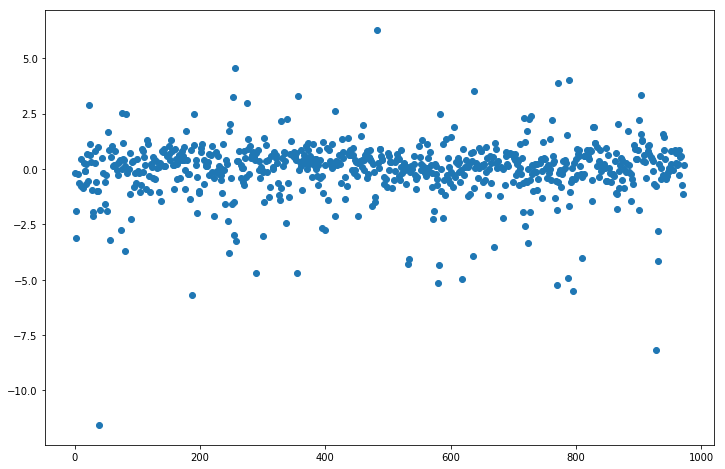

In [323]:
fit_b.resid.plot(style='o', figsize=(12,8));

(array([  1.,   1.,   0.,   8.,  19.,  75., 528.,  77.,   8.,   2.]),
 array([-11.5591392 ,  -9.77424422,  -7.98934923,  -6.20445424,
         -4.41955925,  -2.63466426,  -0.84976928,   0.93512571,
          2.7200207 ,   4.50491569,   6.28981068]),
 <a list of 10 Patch objects>)

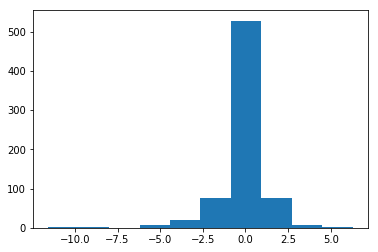

In [324]:
plt.hist(fit_b.resid)

In [316]:
import scipy

In [325]:
scipy.stats.normaltest(fit_b.resid)

NormaltestResult(statistic=368.89151577641996, pvalue=7.874539007812231e-81)

In [286]:
np.random.seed(28041990)

# Code for The Numbers website for direct to video sequels

Below is getting data from The Numbers - include direct-to-video movies which is interesting, but they don't have sales data for all of those direct to video releases so it's tougher to assess. It might be useful down the line.

In [30]:
"""
url = 'https://www.the-numbers.com/movies/franchises'
response = requests.get(url)
response.status_code
# print(response.text)
page = response.text
soup = BeautifulSoup(page,"lxml")
# soup.find_all('table')
# soup.find('table').find_all('tr')[1:]

movie_count = 0
single = 0
franchises = 0
for link in soup.find('table').find_all('tr')[1:]:
    print(link.find('a')['href']) # put .text instead of ['href'] for the name of the franchise
    n = int(link.find_all('td')[1].text)
    print(link.find_all('td')[1].text) # print the next column - the number of movies
    movie_count += int(link.find_all('td')[1].text)
    if n == 1:
        single += 1
    franchises += 1
print(movie_count)
print(franchises)
print(single)
"""

'\nurl = \'https://www.the-numbers.com/movies/franchises\'\nresponse = requests.get(url)\nresponse.status_code\n# print(response.text)\npage = response.text\nsoup = BeautifulSoup(page,"lxml")\n# soup.find_all(\'table\')\n# soup.find(\'table\').find_all(\'tr\')[1:]\n\nmovie_count = 0\nsingle = 0\nfranchises = 0\nfor link in soup.find(\'table\').find_all(\'tr\')[1:]:\n    print(link.find(\'a\')[\'href\']) # put .text instead of [\'href\'] for the name of the franchise\n    n = int(link.find_all(\'td\')[1].text)\n    print(link.find_all(\'td\')[1].text) # print the next column - the number of movies\n    movie_count += int(link.find_all(\'td\')[1].text)\n    if n == 1:\n        single += 1\n    franchises += 1\nprint(movie_count)\nprint(franchises)\nprint(single)\n'